In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf
import numpy as np
import pandas
from matplotlib import pyplot as plt

In [2]:
spark = SparkSession.builder.appName("NYPD 311 Data Analysis").config("spark.some.config.option", "some-value").getOrCreate()

In [3]:
data = spark.read.csv("311_Service_Requests_from_2010_to_Present.csv", header=True)
#noDuplicates = data.distinct()
#print(data.count(), noDuplicates.count())

In [4]:
#data.printSchema()
#checkup = data.select("Complaint Type").filter((col("Complaint Type").rlike("sleep 11*"))).show()
#traumCounseling = data.select("Descriptor", "Complaint Type").filter(col("Descriptor").rlike("Trauma*")).show(123)#.groupBy("Descriptor").count().show()

In [5]:
differentCTypes = data.groupBy("Complaint Type").count().sort("Complaint Type")
differentCTypes.show()
#differentCTypes["count"].show


+--------------------+-----+
|      Complaint Type|count|
+--------------------+-----+
|         $(sleep 11)|    1|
|        ${3804*3137}|    1|
|%2e%2e%2f%2e%2e%2...|    1|
|%2e%2e%5c%2e%2e%5...|    1|
|     %2fetc%2fpasswd|    1|
|%E5%98%8A%E5%98%8...|    1|
|%c0%ae/%c0%ae/%c0...|    1|
|%c0%ae/%c0%ae/%c0...|    1|
|%c0%ae/%c0%ae/WEB...|    1|
|%c0%ae/WEB-INF/we...|    1|
|%{(#dm=@ognl.Ognl...|    1|
|        %{4761*8506}|    1|
|&lt;odb xmlns:xi=...|    1|
|&lt;vlv xmlns=&qu...|    1|
|&quot;--&gt;'--&g...|    1|
|() { :;}; /bin/sl...|    1|
|() { :;}; /bin/sl...|    1|
|     () { _; } &gt;_|    1|
|(select extractva...|    1|
|(select load_file...|    1|
+--------------------+-----+
only showing top 20 rows



In [6]:
overall = differentCTypes.toPandas()
overall = overall.iloc[44:461]
overall.to_csv("allComplaintTypesWithCounts.csv")
#plot = overall.plot.bar( figsize = (20,20))
#print(overall[22:].shape)
#overall = overall[44:]
#print(overall[:22])

#### 

In [7]:
# Animal Abuse
animal_filtered = data.select("Unique Key","Complaint Type", "Borough", "Created Date").filter(col("Complaint Type").rlike("Animal*")).persist()
animal_filtered.show()

+----------+----------------+-------------+--------------------+
|Unique Key|  Complaint Type|      Borough|        Created Date|
+----------+----------------+-------------+--------------------+
|  52729912|    Animal-Abuse|     BROOKLYN|12/07/2021 09:39:...|
|  52729959|    Animal-Abuse|       QUEENS|12/07/2021 08:10:...|
|  52731050|    Animal-Abuse|     BROOKLYN|12/07/2021 03:56:...|
|  52731051|    Animal-Abuse|     BROOKLYN|12/08/2021 01:39:...|
|  52731197|    Animal-Abuse|        BRONX|12/07/2021 04:38:...|
|  52731312|     Dead Animal|     BROOKLYN|12/07/2021 02:30:...|
|  52731437|     Dead Animal|     BROOKLYN|12/07/2021 11:31:...|
|  52732627|     Dead Animal|     BROOKLYN|12/07/2021 09:29:...|
|  52732773|    Animal-Abuse|       QUEENS|12/07/2021 02:31:...|
|  52732813|    Animal-Abuse|STATEN ISLAND|12/07/2021 05:52:...|
|  52733717|    Animal-Abuse|STATEN ISLAND|12/07/2021 08:25:...|
|  52733718|    Animal-Abuse|       QUEENS|12/07/2021 10:23:...|
|  52733873|     Dead Ani

In [8]:
years = lambda date: date.split(" ")[0].split("/")[2]
fuse = lambda typ: typ.replace("-", " ")
udfyears = udf(years)
udffuse = udf(fuse)
animal_abuse = animal_filtered.withColumn("Complaint Type", udffuse("Complaint type")).withColumn("Created Date", udfyears("Created Date").cast("Integer")).filter(col("Complaint Type").rlike("Animal Abuse"))
results_total = animal_abuse.groupBy("Borough").count().sort("Borough")
results_total.show()
#results_total.toPandas().to_csv("AnimalAbuseTotalNumberPerBoro.csv")

results_mean = animal_abuse.groupBy("Borough").mean()
results = animal_abuse.drop("Complaint Type").groupBy("Created Date").pivot("Borough").count().sort("Created Date").fillna(0).persist()#.filter(col("Borough") != "Unspecified")#.sort("Borough", "Created Date").persist()
#results.toPandas().to_csv("AnimalAbuseCountPerYear.csv")
#results_year = results.filter((col("Created Date")==2015) | (col("Created Date")==2020)).sort("Created Date","Borough")
results.show()
#results.toPandas().to_csv("AnimalAbuseTotalNumberPerBoroPerYear.csv")
animal_abuse.show()

+-------------+-----+
|      Borough|count|
+-------------+-----+
|        BRONX|14198|
|     BROOKLYN|21995|
|    MANHATTAN|13200|
|       QUEENS|19229|
|STATEN ISLAND| 5175|
|  Unspecified|   53|
+-------------+-----+

+------------+-----+--------+---------+------+-------------+-----------+
|Created Date|BRONX|BROOKLYN|MANHATTAN|QUEENS|STATEN ISLAND|Unspecified|
+------------+-----+--------+---------+------+-------------+-----------+
|        2013|  799|       0|        4|     1|            1|          0|
|        2014| 1767|    2743|     1495|  2457|          694|          2|
|        2015| 1971|    3191|     1941|  2640|          786|         12|
|        2016| 1866|    2861|     1877|  2671|          786|          7|
|        2017| 1648|    2740|     1564|  2562|          668|          9|
|        2018| 1603|    2592|     1651|  2223|          615|         18|
|        2019| 1488|    2356|     1488|  2065|          526|          5|
|        2020| 1310|    2118|     1195|  1792|   

[[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
 [ 799 1767 1971 1866 1648 1603 1488 1310 1127  619]
 [   0 2743 3191 2861 2740 2592 2356 2118 2276 1118]
 [   4 1495 1941 1877 1564 1651 1488 1195 1289  696]
 [   1 2457 2640 2671 2562 2223 2065 1792 1741 1077]
 [   1  694  786  786  668  615  526  481  389  229]
 [   0    2   12    7    9   18    5    0    0    0]]


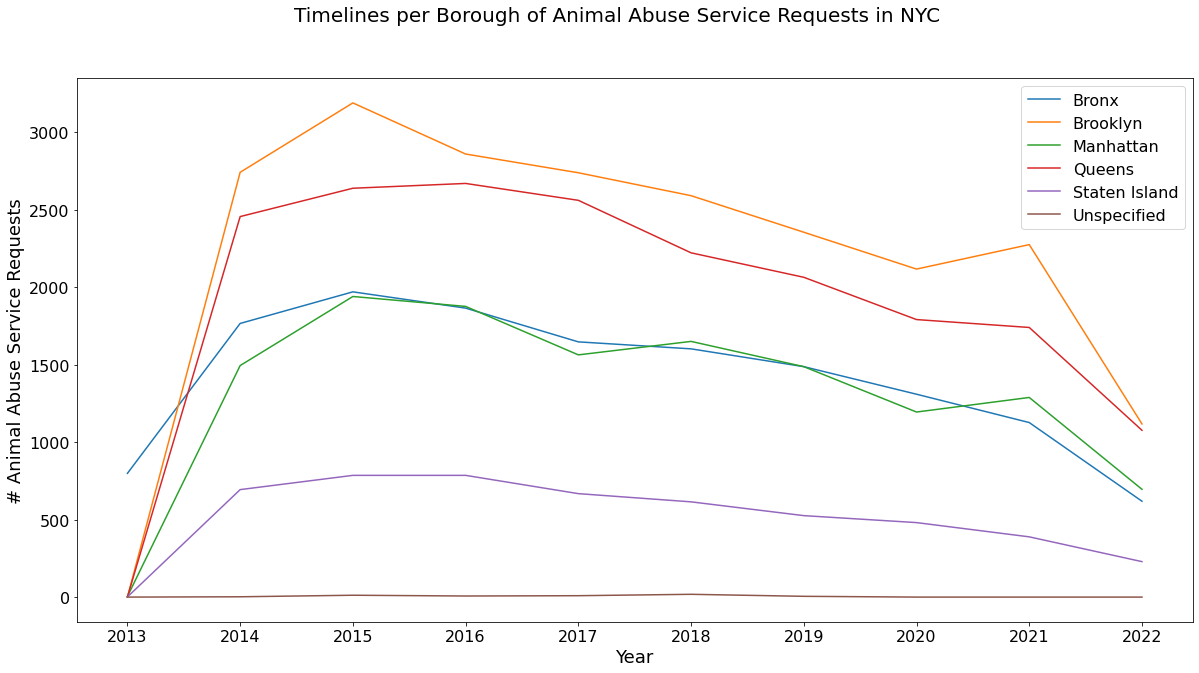

In [9]:
timelines = results.toPandas().to_numpy().transpose()
print(timelines)
fig = plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = 16
fig.suptitle("Timelines per Borough of Animal Abuse Service Requests in NYC", fontsize=20)
plt.tight_layout()
plt.plot(timelines[0], timelines[1], label="Bronx")
plt.plot(timelines[0], timelines[2], label="Brooklyn")
plt.plot(timelines[0], timelines[3], label="Manhattan")
plt.plot(timelines[0], timelines[4], label="Queens")
plt.plot(timelines[0], timelines[5], label="Staten Island")
plt.plot(timelines[0], timelines[6], label="Unspecified")
plt.xlabel("Year", fontsize=18)
plt.xticks(timelines[0])
plt.ylabel("# Animal Abuse Service Requests", fontsize=18)
plt.legend()
fig.savefig("AnimalAbuseTimelines(2013-2021).pdf")
plt.show()

[14198 21995 13200 19229  5175    53]


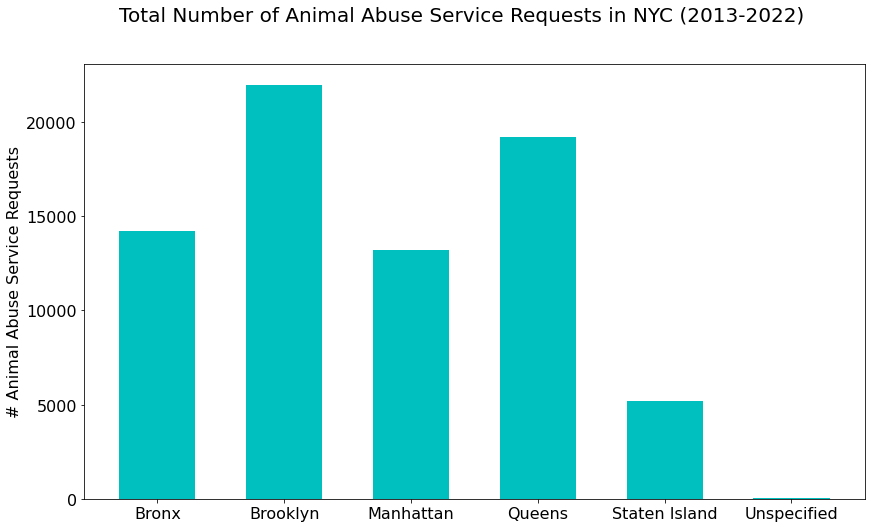

In [10]:
total= results_total.drop("Borough").toPandas().to_numpy().flatten()
print(total)
labels = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island", "Unspecified"]
x = np.arange(len(labels))
fig = plt.figure(figsize=(14,8))
plt.rcParams['font.size'] = 16
fig.suptitle("Total Number of Animal Abuse Service Requests in NYC (2013-2022)", fontsize=20)
plt.tight_layout()
plt.bar(x, total, 0.6, color="c")
plt.xticks(x, labels=labels)
plt.ylabel("# Animal Abuse Service Requests")
#plt.xticklabels(labels)
fig.savefig("TotalNumberAnimalAbuse.pdf")
plt.show()

In [11]:
#results_mean = results.groupBy("Complaint Type", "Borough").mean().filter(col("Borough") != "Unspecified").drop("avg(Created Date)")
#results_mean.show()
#results_total = results.groupBy("Complaint Type", "Borough").sum().filter(col("Borough") != "Unspecified").drop("sum(Created Date)")
#results_total.show()
#results_year.show()

In [12]:
# Xmas Trees 
#months = ["January", "February", "March", "April", "June", "July", "August", "September", "October", "November", "December"]
#x = np.arange(len(months))
mon = lambda date: date.split(" ")[0].split("/")[0]
udfmonth = udf(mon)
day = lambda date: date.split(" ")[0].split("/")[1]
udfday = udf(day)

xmas_data = data.select("Created Date", "Complaint Type", "Closed Date").filter(col("Complaint Type").rlike("Xmas*")).withColumn("Created Month", udfmonth("Created Date").cast("Integer")).withColumn("Created Day", udfday("Created Date").cast("Integer")).withColumn("Closed Month", udfmonth("Closed Date").cast("Integer")).withColumn("Closed Day", udfday("Closed Date").cast("Integer")).drop("Created Date", "Closed Date").persist()
xmas_data.show()

+--------------------+-------------+-----------+------------+----------+
|      Complaint Type|Created Month|Created Day|Closed Month|Closed Day|
+--------------------+-------------+-----------+------------+----------+
|Request Xmas Tree...|            1|         22|           1|        24|
|Request Xmas Tree...|            1|         22|           1|        24|
|Request Xmas Tree...|            1|         18|           1|        19|
|Request Xmas Tree...|            1|         18|           1|        19|
|Request Xmas Tree...|            1|         19|           1|        24|
|Request Xmas Tree...|            1|         14|           1|        14|
|Request Xmas Tree...|            1|         24|           1|        24|
|Request Xmas Tree...|            1|         26|           1|        27|
|Request Xmas Tree...|            1|         26|           1|        28|
|Request Xmas Tree...|            1|         14|           1|        16|
|Request Xmas Tree...|            1|         14|   

In [60]:
#additional df
days_jan = np.arange(1,32, dtype=np.int)
days_feb = np.arange(1,29, dtype=np.int)
jan = np.ones(31)
feb = np.repeat(2,28)
zero = np.zeros(31)
columns = ['Created Month', 'Created Day', 'count']
#vals = [()]
vals_jan = np.append([jan], [days_jan], axis=0)
#print(vals_jan)
vals_jan = np.append(vals_jan, [zero], axis=0).transpose()
vals_feb = np.append([feb], [days_feb], axis=0)
#print(vals_jan
vals_feb = np.append(vals_feb, [zero[:28]], axis=0).transpose()
#vals_feb = np.append([feb], [days_feb], [np.zeros(28)], axis=0).transpose()
#print(vals_feb)
df1 = spark.createDataFrame(pandas.DataFrame(vals_jan, columns=columns))
df2 = spark.createDataFrame(pandas.DataFrame(vals_feb, columns=columns))
#df1 = spark.createDataFrame(df1)
df1.show()

art_df = df1.union(df2)
art_df_closed = art_df.withColumnRenamed('Created Month','Closed Month').withColumnRenamed('Created Day','Closed Day')
art_df_closed.show()

+-------------+-----------+-----+
|Created Month|Created Day|count|
+-------------+-----------+-----+
|          1.0|        1.0|  0.0|
|          1.0|        2.0|  0.0|
|          1.0|        3.0|  0.0|
|          1.0|        4.0|  0.0|
|          1.0|        5.0|  0.0|
|          1.0|        6.0|  0.0|
|          1.0|        7.0|  0.0|
|          1.0|        8.0|  0.0|
|          1.0|        9.0|  0.0|
|          1.0|       10.0|  0.0|
|          1.0|       11.0|  0.0|
|          1.0|       12.0|  0.0|
|          1.0|       13.0|  0.0|
|          1.0|       14.0|  0.0|
|          1.0|       15.0|  0.0|
|          1.0|       16.0|  0.0|
|          1.0|       17.0|  0.0|
|          1.0|       18.0|  0.0|
|          1.0|       19.0|  0.0|
|          1.0|       20.0|  0.0|
+-------------+-----------+-----+
only showing top 20 rows

+------------+----------+-----+
|Closed Month|Closed Day|count|
+------------+----------+-----+
|         1.0|       1.0|  0.0|
|         1.0|       2.0|  0.0

In [61]:
#xmas_data.show()

In [62]:
xmas_created = xmas_data.groupBy("Created Month", "Created Day").count().sort("Created Month", "Created Day")
xmas_closed = xmas_data.groupBy("Closed Month", "Closed Day").count().sort("Closed Month", "Closed Day")
xmas_created = xmas_created.union(art_df).groupBy("Created Month", "Created Day").sum('count').sort("Created Month", "Created Day")
xmas_created.show()
xmas_closed = xmas_closed.union(art_df_closed).groupBy("Closed Month", "Closed Day").sum('count').sort("Closed Month", "Closed Day")

+-------------+-----------+----------+
|Created Month|Created Day|sum(count)|
+-------------+-----------+----------+
|          1.0|        1.0|       0.0|
|          1.0|        2.0|       0.0|
|          1.0|        3.0|       0.0|
|          1.0|        4.0|       1.0|
|          1.0|        5.0|       0.0|
|          1.0|        6.0|       0.0|
|          1.0|        7.0|       1.0|
|          1.0|        8.0|       0.0|
|          1.0|        9.0|       0.0|
|          1.0|       10.0|       0.0|
|          1.0|       11.0|       0.0|
|          1.0|       12.0|       0.0|
|          1.0|       13.0|       0.0|
|          1.0|       14.0|     182.0|
|          1.0|       15.0|     176.0|
|          1.0|       16.0|     107.0|
|          1.0|       17.0|      82.0|
|          1.0|       18.0|      51.0|
|          1.0|       19.0|     156.0|
|          1.0|       20.0|     113.0|
+-------------+-----------+----------+
only showing top 20 rows



In [63]:
#xmas_created.toPandas().to_csv("XmasTreeRequestCreated.csv")
#xmas_closed.toPandas().to_csv("XmasTreeRequestClosed.csv")
# xmas_created_jan = xmas_created.filter(col("Created Month")==1).sort("Created Day")
# xmas_created_feb = xmas_created.filter(col("Created Month")==2).sort("Created Day")
# xmas_closed_jan = xmas_closed.filter(col("Closed Month")==1).sort("Closed Day")
# xmas_closed_feb = xmas_closed.filter(col("Closed Month")==2).sort("Closed Day")
# #xmas_data.show()
# xmas_created_feb.show()
#xmas_closed_feb.show()



In [64]:
distr_created = xmas_created.toPandas().to_numpy().transpose()
distr_closed = xmas_closed.toPandas().to_numpy().transpose()
#distr_created_feb = xmas_xmas_createdcreated_feb.toPandas().to_numpy().transpose()
#distr_closed_feb = xmas_closed_feb.toPandas().to_numpy().transpose()

print(distr_created)

[[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
    2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
    2.   2.   2.]
 [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
   15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
   29.  30.  31.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
   12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.
   26.  27.  28.]
 [  0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0. 182.
  176. 107.  82.  51. 156. 113.  97.  66. 187. 167. 166. 134.  88.  56.
   45.  52.  28.  31.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]]


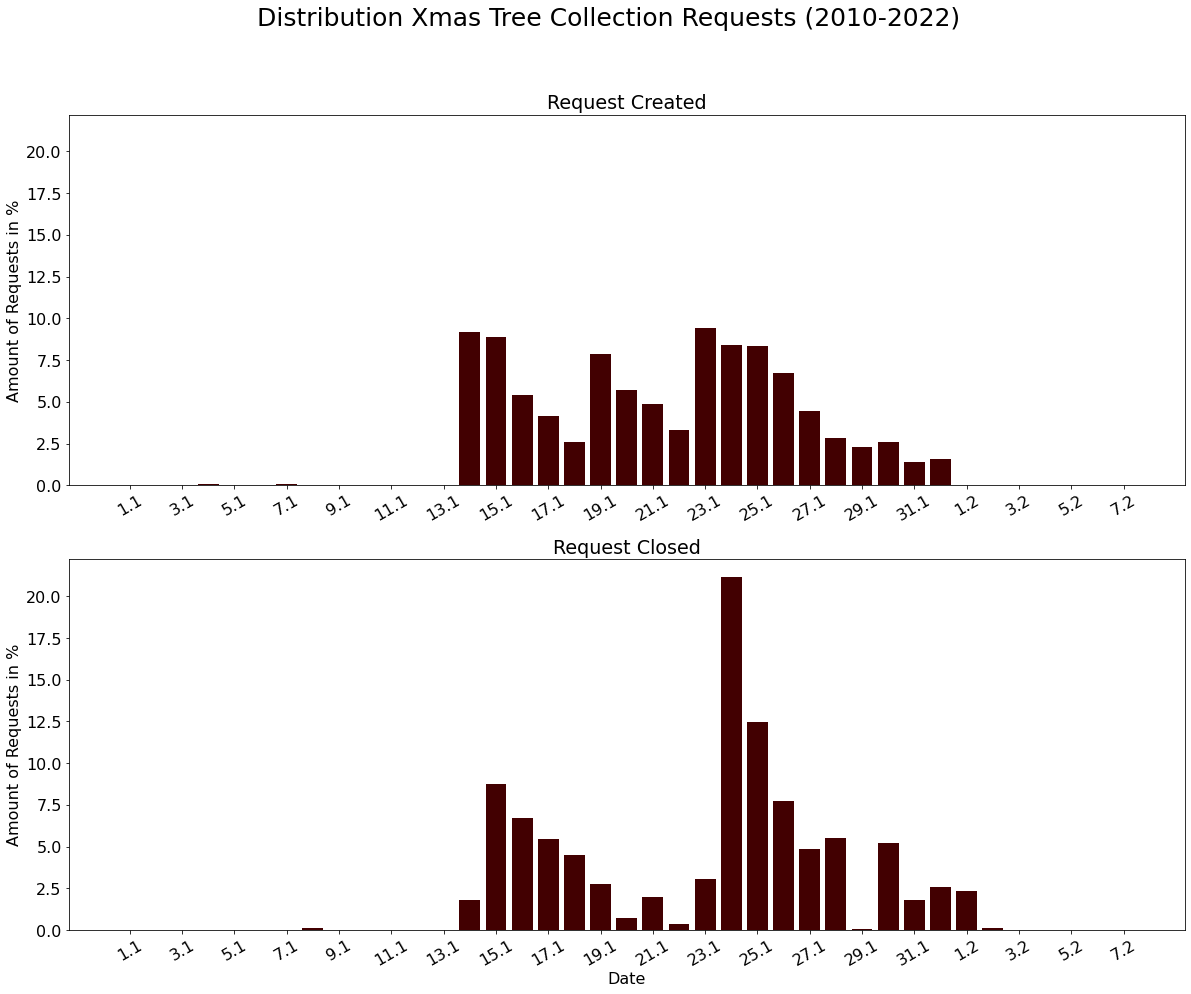

In [115]:
# tree histograms
step = 2
x = np.arange(1,35)
labels = []
for i in range(1,32,step):
    string = str(i)+"."+"1"
    labels.append(string)
for i in range(1,9,step):
    string = str(i)+"."+"2"
    labels.append(string)
#
#print(labels)
x = np.arange(31+28)
#print(x)
pos = np.arange(0,32+8,step)
#print(pos)
fig, ax = plt.subplots(2,1, figsize=(20,15), sharey = True)
fig.suptitle("Distribution Xmas Tree Collection Requests (2010-2022)", fontsize=25)
#plt.tight_layout()
ax[0].bar(x[:-20], distr_created[2][:-20]/np.sum(distr_created[2][:-20])*100, color="#420001")
ax[0].set_title("Request Created")
ax[0].set_xticks(pos)
ax[0].set_xticklabels(labels, rotation=30)
ax[0].set_ylabel("Amount of Requests in %")
#plt.setp(ax[0].get_xticklabels(), visible=True)
#ax[0,1].bar(distr_created_feb[1], distr_created_feb[2])
#ax[0,1].set_title("Request Created (February)")
ax[1].bar(x[:-20], distr_closed[2][:-20]/np.sum(distr_closed[2][:-20])*100, color="#420001")
ax[1].set_title("Request Closed")
ax[1].set_xticks(pos)
ax[1].set_xticklabels(labels, rotation=30)
ax[1].set_ylabel("Amount of Requests in %")
ax[1].set_xlabel("Date")
#fig.savefig("DistributionXmasTreeCollection.pdf")
#ax[1,1].bar(distr_closed_feb[1], distr_closed_feb[2])
#ax[1,1].set_title("Request Closed (February)")
#fig.savefig("absNumberAnimalAbuse.pdf")
plt.show()




In [ ]:
#results_mean.show()
# Timelines
#results_timelines = results

In [ ]:
# results_counts = results_year.select("count").toPandas().to_numpy()
# labels = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
# x = np.arange(len(labels))
# print(x)
# print(results_counts.shape)
# early = results_counts[:5,0]
# late = results_counts[5:len(results_counts),0]
# print(late)

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(12,5))
# fig.suptitle("Absolute Numbers of Animal Abuse Service Requests in NYC", fontsize=17)
# ax.bar(x-0.2, early, 0.4, label="2015", color="#decd96")
# ax.set_xticks(x)
# ax.set_xticklabels(labels, fontsize=14)
# ax.bar(x+0.2, late, 0.4, label = "2020", color="#81bdab")
# ax.set_ylabel("#Animal Abuse", fontsize=12)
# ax.legend(fontsize=12)
# #fig.savefig("absNumberAnimalAbuse.pdf")
# plt.show()